In [51]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [52]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

# metric_key = f"{metric_key_unsmoothed}_smoothed"
metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [36]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (29837, 55), Eval: (8122, 55)


<Axes: ylabel='Frequency'>

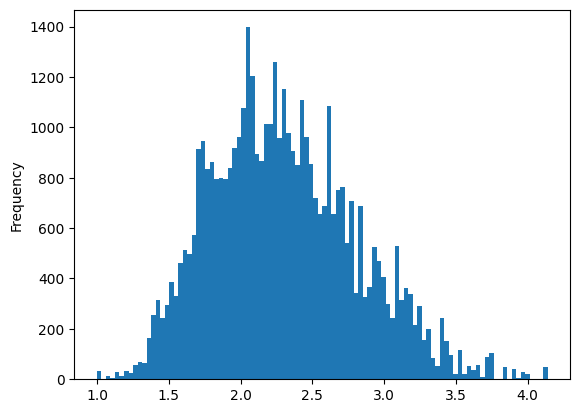

In [37]:
df["weight"].plot.hist(bins = 100)

In [38]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
29,2007,2.271493e+06,0.393871,0.983720
105,2008,2.333333e+06,0.105263,0.022257
432,2009,1.920000e+06,-0.154741,-0.316067
4784,2010,2.037037e+06,-0.126984,-0.215148
6463,2011,1.444444e+06,-0.247685,-0.672931
8653,2012,1.455556e+06,-0.285455,-0.658649
12133,2013,2.303030e+06,0.594406,1.149448
15390,2014,2.000000e+06,0.374046,0.689789
17451,2015,2.173913e+06,-0.056064,-0.243456
21036,2016,2.645833e+06,0.322917,0.263091


In [39]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
223,2020,3.787942e+06,0.237409,0.186068
3783,2021,4.420875e+06,0.312098,0.326362
5648,2022,4.333333e+06,0.143981,0.108697


In [40]:
idx = 2995
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window

Target: -0.3109314767489717


,area_code,area,year,asset_type,unit_price_median_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight,time_diff
24167,12232,Chiba-ken Shiroi-shi,2015,land,0.636364,-0.446429,0.058824,0.003022,0.015001,0.008684,0.005088,0.020779,0.006263,63000.0,31.0,12955.0,2613.0,2297.0,62105.0,27637.0,100304791.0,3629.366103,8937208.0,493.0,23726.0,0.908864,-0.321694,-0.325078,0.652259,0.528106,0.535309,0.672858,0.802086,1.749559,0.697382,-0.017851,-0.586394,1.341296,-1.170965,-0.053636,0.037179,0.202820,-0.026397,1.115622,0.896307,0.459960,1,1,1,1,1,0.0,1.0,4.793134,2.345665,6
25264,12232,Chiba-ken Shiroi-shi,2016,land,-0.008403,-0.161290,-0.063492,0.008170,0.003230,-0.017217,0.001906,0.016640,0.020805,59000.0,26.0,9715.0,2345.0,2226.0,62421.0,28212.0,100628779.0,3566.878598,9010227.0,403.0,24219.0,0.839742,-0.456117,-0.550213,0.606918,0.531276,0.539821,0.676922,0.789958,1.563813,0.695383,-0.214715,-0.576844,-0.184140,-0.495369,-0.252963,0.052901,-0.613939,-0.973282,0.613023,0.308090,0.356242,1,1,1,1,1,0.0,1.0,4.795338,2.347870,5
29302,12232,Chiba-ken Shiroi-shi,2017,land,-0.023810,0.000000,0.042373,0.015671,0.017165,0.002279,0.005453,0.012103,0.014852,61500.0,26.0,13095.0,2359.0,2018.0,62540.0,28631.0,102356063.0,3575.008313,9151426.0,298.0,24622.0,0.864665,-0.450082,-0.289904,0.613284,0.470171,0.542201,0.679492,0.788897,1.520816,0.696631,-0.423065,-0.572792,-0.209364,-0.127826,-0.069969,0.242041,-0.001931,-0.169301,1.037849,-0.247232,0.270498,1,1,1,1,1,0.0,1.0,4.796165,2.344993,4
31066,12232,Chiba-ken Shiroi-shi,2018,land,0.186441,0.038462,0.138211,-0.003604,0.014834,-0.000010,-0.002226,0.009029,0.014844,70000.0,27.0,8465.0,1973.0,2113.0,62881.0,29056.0,103874423.0,3574.973259,9118441.0,225.0,24920.0,0.965018,-0.391434,-0.677973,0.509864,0.501644,0.546876,0.683701,0.786102,1.438627,0.687577,-0.660017,-0.572040,0.181939,-0.036439,-0.004385,-0.231213,-0.056471,-0.274701,0.178801,-0.675144,0.463745,1,1,1,1,1,0.0,1.0,4.798526,2.346740,3
33882,12232,Chiba-ken Shiroi-shi,2019,land,0.252033,-0.222222,0.100000,0.017935,0.010575,0.001680,-0.004782,0.017273,0.008879,77000.0,21.0,12205.0,1821.0,2121.0,62741.0,29314.0,104972862.0,3580.980487,9281979.0,438.0,25358.0,1.048455,-0.564057,-0.283191,0.468757,0.504508,0.546650,0.684966,0.783206,1.398535,1.031664,-0.091466,-0.565564,0.133496,-0.500445,-0.009932,0.234829,0.041583,-0.128881,-0.069659,0.833932,0.380169,1,1,1,1,1,0.0,1.0,4.797558,2.345772,2


In [41]:
log_normalize_columns = [
    metric,
    # "count",
    # "total_traded_area",
    # "in_migrations",
    # "out_migrations",
    # "population",
    # "taxpayer_count",
    # "taxable_income",
    # "taxable_income_per_taxpayer",
    # "total_tax",
    # "new_dwellings",
    # "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    # "yearly_price_growth",
    # "count_growth",
    # "total_tax_growth",
    # "taxable_income_growth",
    # "taxable_income_per_taxpayer_growth",
    # "net_migration_ratio",
    # "new_dwellings_ratio",
    # "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    # "migrations_is_available",
    # "taxable_income_is_available",
    # "dwellings_is_available",
    # "total_tax_is_available",
    # "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [42]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 27) (1,) [-0.69141473] [3.13587287]
1 (1, 27) (1,) [0.47067904] [3.22549216]
2 (1, 27) (1,) [-0.9038856] [2.46305168]
3 (1, 27) (1,) [-0.10144348] [3.91386995]
0 torch.Size([5, 27]) torch.Size([1]) tensor([-0.6914]) tensor([3.1359])
1 torch.Size([5, 27]) torch.Size([1]) tensor([0.4707]) tensor([3.2255])
2 torch.Size([5, 27]) torch.Size([1]) tensor([-0.9039]) tensor([2.4631])
3 torch.Size([5, 27]) torch.Size([1]) tensor([-0.1014]) tensor([3.9139])


In [43]:
BATCH_SIZE = 256

In [44]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [45]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [46]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [47]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 27]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.8661386966705322


In [48]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 50

In [49]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [50]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 6.7352, Eval Loss: 5.6795
Train R^2: 0.1342, Eval R^2: 0.2690
Epoch: 1
Train Loss: 5.3886, Eval Loss: 5.1896
Train R^2: 0.3100, Eval R^2: 0.3289
Epoch: 2
Train Loss: 5.0697, Eval Loss: 4.9196
Train R^2: 0.3513, Eval R^2: 0.3601
Epoch: 3
Train Loss: 4.8649, Eval Loss: 4.9272
Train R^2: 0.3763, Eval R^2: 0.3584
Epoch: 4
Train Loss: 4.7570, Eval Loss: 4.8580
Train R^2: 0.3899, Eval R^2: 0.3674
Epoch: 5
Train Loss: 4.6519, Eval Loss: 4.7701
Train R^2: 0.4033, Eval R^2: 0.3777
Epoch: 6
Train Loss: 4.5741, Eval Loss: 4.7208
Train R^2: 0.4137, Eval R^2: 0.3836
Epoch: 7
Train Loss: 4.5483, Eval Loss: 4.6986
Train R^2: 0.4171, Eval R^2: 0.3845
Epoch: 8
Train Loss: 4.4863, Eval Loss: 4.6642
Train R^2: 0.4254, Eval R^2: 0.3891
Epoch: 9
Train Loss: 4.4039, Eval Loss: 4.6417
Train R^2: 0.4365, Eval R^2: 0.3924
Epoch: 10
Train Loss: 4.3258, Eval Loss: 4.6147
Train R^2: 0.4462, Eval R^2: 0.3963
Epoch: 11
Train Loss: 4.2278, Eval Loss: 4.6353
Train R^2: 0.4599, Eval R^2: 0.3946
Ep

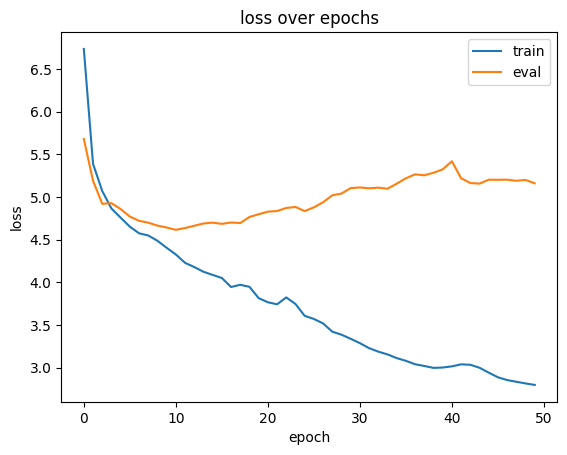

In [54]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

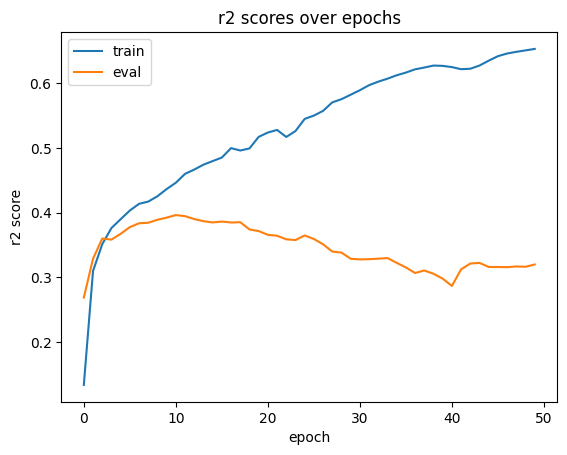

In [55]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [36]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [37]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18074,2022,27221,-1.298147,-0.313324,-1.323509
17324,2022,28212,-0.249031,-0.147399,-0.663334
17318,2022,15206,-0.854303,-0.233155,-1.004535
17319,2022,47348,1.672437,0.423042,1.606304
17320,2022,21361,-1.572772,-0.572982,-2.356621
...,...,...,...,...,...
15411,2020,24203,-0.396602,-0.157997,-1.050942
15410,2020,8214,-0.022239,-0.030913,-0.309195
15409,2020,27203,0.457672,0.166667,0.844006
15408,2020,14341,-0.595804,-0.160141,-1.063457


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

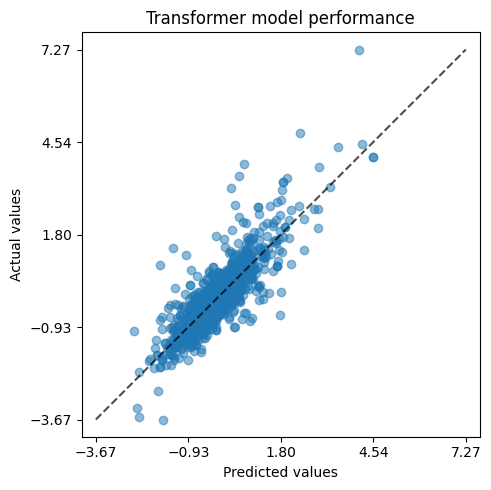

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

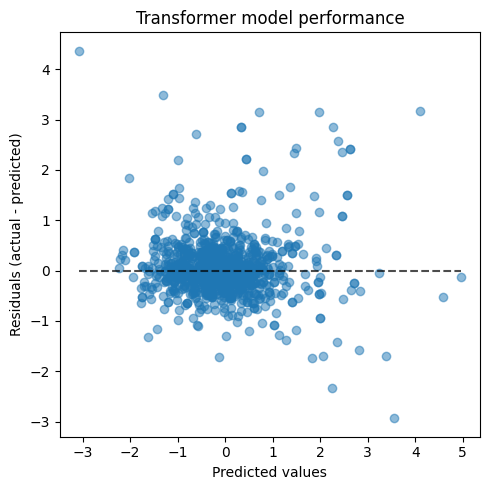

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()